<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/Python/IDW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IDW Method

In [1]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.5 MB/s eta 0:00:00


In [2]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 17.7 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import xarray as xr
import time
from scipy.spatial import cKDTree

# Start Timer
start_time = time.time()

# Load Data
print("Loading data...")
data = pd.read_csv('basePM25nearest_grid.csv')  # Your CSV file
model_data = xr.open_dataset('BaseCase_PERT_PM25_rh50_YEARLY.nc')  # Model NetCDF file

# Extract Model Data
model_lons = model_data['lon'].values
model_lats = model_data['lat'].values
model_values = model_data['SURF_ug_PM25_rh50'].values[0].astype(np.float32)  # Use float32 to reduce memory usage

# Extract Station Data
stations_data = data[['lon', 'lat', 'SURF_ug_PM25_rh50']].copy()
stations_data['nearest_SURF_ug_PM25_rh50'] = data['nearest_SURF_ug_PM25_rh50']

# Compute Bias (Observed - Modeled)
stations_data['bias'] = stations_data['SURF_ug_PM25_rh50'] - stations_data['nearest_SURF_ug_PM25_rh50']

# IDW Interpolation Function
def idw_interpolation(grid_lon, grid_lat, stations_data, power=2, num_neighbors=10):
    """Applies Inverse Distance Weighting (IDW) interpolation."""
    station_coords = np.vstack((stations_data['lon'].values, stations_data['lat'].values)).T
    bias_values = stations_data['bias'].values

    # Properly structure the model grid
    grid_x, grid_y = np.meshgrid(grid_lon, grid_lat, indexing='xy')
    grid_coords = np.vstack((grid_x.ravel(), grid_y.ravel())).T

    # Create KDTree for nearest neighbor searches
    tree = cKDTree(station_coords)
    distances, indices = tree.query(grid_coords, k=num_neighbors)  # Use 10 nearest neighbors for accuracy

    # Avoid division by zero
    distances[distances == 0] = 1e-10

    # Compute weights using inverse distance
    weights = 1.0 / np.power(distances, power)
    weights /= weights.sum(axis=1, keepdims=True)  # Normalize weights

    # Apply IDW formula
    interpolated_bias = np.sum(weights * bias_values[indices], axis=1)

    # ✅ Corrected reshaping to match model grid
    return interpolated_bias.reshape(len(grid_lat), len(grid_lon))


# Apply IDW Interpolation
print("Interpolating bias using IDW...")
z_bias = idw_interpolation(model_lons, model_lats, stations_data)

# Apply Bias Correction
print("Applying bias correction to model data...")
corrected_values = model_values + z_bias
corrected_data = model_data.copy()

# Add the corrected variable
corrected_data["SURF_ug_PM25_rh50_corrected"] = (["time", "lat", "lon"], corrected_values[np.newaxis, :, :])

# Preserve metadata (FIXED ISSUE)
corrected_data["SURF_ug_PM25_rh50_corrected"].attrs = model_data["SURF_ug_PM25_rh50"].attrs
corrected_data.attrs["description"] = "Bias-corrected PM2.5 using IDW interpolation"

# Save Corrected Data
print("Saving corrected NetCDF file...")
corrected_data.to_netcdf('BaseCase_PERT_PM25_rh50_YEARLY_corrected.nc')

# End Timer
end_time = time.time()
print(f"✅ Bias-corrected NetCDF saved as: BaseCase_PERT_PM25_rh50_YEARLY_corrected.nc")
print(f"Total execution time: {end_time - start_time:.2f} seconds")


Loading data...
Interpolating bias using IDW...
Applying bias correction to model data...
Saving corrected NetCDF file...
✅ Bias-corrected NetCDF saved as: BaseCase_PERT_PM25_rh50_YEARLY_corrected.nc
Total execution time: 0.99 seconds


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


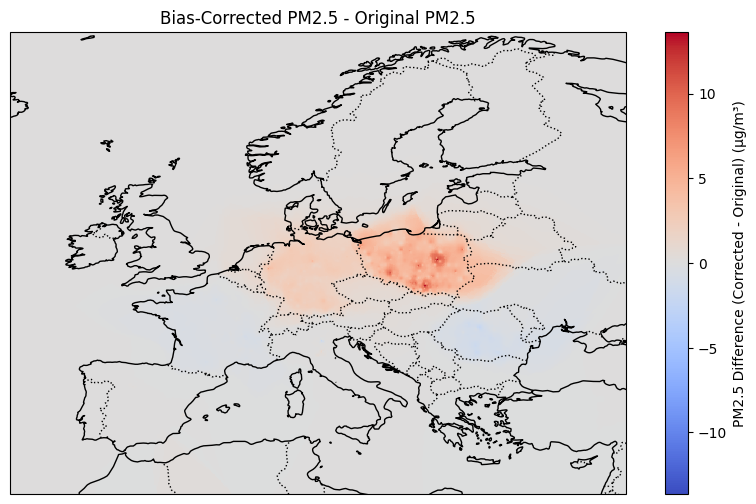

In [6]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# === Load Data ===
original_nc = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_nc = "BaseCase_PERT_PM25_rh50_YEARLY_corrected.nc"

# Open datasets
ds_original = xr.open_dataset(original_nc)
ds_corrected = xr.open_dataset(corrected_nc)

# Extract PM2.5 data
pm25_original = ds_original["SURF_ug_PM25_rh50"].values.squeeze()
pm25_corrected = ds_corrected["SURF_ug_PM25_rh50_corrected"].values.squeeze()

# Compute difference
pm25_difference = pm25_corrected - pm25_original

# Extract coordinates
lons = ds_original["lon"].values
lats = ds_original["lat"].values

# === Define a logarithmic normalization ===
norm = mcolors.CenteredNorm(vcenter=0)  # Center around 0 for positive and negative changes

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot PM2.5 difference using pcolormesh with log scaling
mesh = ax.pcolormesh(lons, lats, pm25_difference, cmap='coolwarm', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with centered scale
plt.colorbar(mesh, label="PM2.5 Difference (Corrected - Original) (µg/m³)")

# Add coastlines and borders for geographic context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Title
plt.title("Bias-Corrected PM2.5 - Original PM2.5")

# Show the plot
plt.show()

# Close datasets
ds_original.close()
ds_corrected.close()



## Best hyperparameters - search

In [39]:
import numpy as np
import pandas as pd
import xarray as xr
from scipy.spatial import cKDTree
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Load station data
data = pd.read_csv("basePM25nearest_grid.csv")

# Compute bias (Observed - Modeled)
data["PM25_Bias"] = data["SURF_ug_PM25_rh50"] - data["nearest_SURF_ug_PM25_rh50"]

# Extract station locations and bias values
station_coords = data[["lon", "lat"]].values
bias_values = data["PM25_Bias"].values

# Hyperparameter search space
power_values = [1, 2, 3, 4, 5, 10, 15]  # Different weight decay factors
neighbor_values = [5, 10, 15, 20, 25, 30, 35, 40]  # Different nearest neighbor counts

# Set up k-fold cross-validation
kf = KFold(n_splits=50, shuffle=True, random_state=42)

# Store results
results = []

# Perform grid search
for p in power_values:
    for k in neighbor_values:
        errors = []

        for train_index, test_index in kf.split(station_coords):
            # Split training and testing data
            train_coords, test_coords = station_coords[train_index], station_coords[test_index]
            train_bias, test_bias = bias_values[train_index], bias_values[test_index]

            # Build KDTree
            tree = cKDTree(train_coords)
            distances, indices = tree.query(test_coords, k=k)

            # Avoid division by zero
            distances[distances == 0] = 1e-10

            # Compute weights using IDW
            weights = 1.0 / np.power(distances, p)
            weights /= weights.sum(axis=1, keepdims=True)  # Normalize weights

            # Predict bias at test locations
            predicted_bias = np.sum(weights * train_bias[indices], axis=1)

            # Compute RMSE
            error = np.sqrt(mean_squared_error(test_bias, predicted_bias))
            errors.append(error)

        # Store mean RMSE for this (p, k) pair
        mean_rmse = np.mean(errors)
        results.append((p, k, mean_rmse))

        #print(f"Tested p={p}, k={k} → RMSE: {mean_rmse:.4f}")

# Find the best hyperparameter combination
best_p, best_k, best_rmse = min(results, key=lambda x: x[2])
print(f"\n Best hyperparameters: p={best_p}, k={best_k} → RMSE: {best_rmse:.4f}")

# === Load Model Data ===
model_nc = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
ds_model = xr.open_dataset(model_nc)

# Extract Model Data
model_lons = ds_model["lon"].values
model_lats = ds_model["lat"].values
model_values = ds_model["SURF_ug_PM25_rh50"].values[0].astype(np.float32)

# === IDW Interpolation Function ===
def idw_interpolation(grid_lon, grid_lat, stations_data, power, num_neighbors):
    """Applies Inverse Distance Weighting (IDW) interpolation."""
    station_coords = np.vstack((stations_data['lon'].values, stations_data['lat'].values)).T
    bias_values = stations_data["PM25_Bias"].values

    # Create grid
    grid_x, grid_y = np.meshgrid(grid_lon, grid_lat, indexing='xy')
    grid_coords = np.column_stack((grid_x.ravel(), grid_y.ravel()))

    # Build KDTree
    tree = cKDTree(station_coords)
    distances, indices = tree.query(grid_coords, k=num_neighbors)

    # Avoid division by zero
    distances[distances == 0] = 1e-10

    # Compute weights using IDW
    weights = 1.0 / np.power(distances, power)
    weights /= weights.sum(axis=1, keepdims=True)

    # Compute interpolated bias
    interpolated_bias = np.sum(weights * bias_values[indices], axis=1)

    # Reshape
    return interpolated_bias.reshape(len(grid_lat), len(grid_lon))

# === Apply IDW with Best Hyperparameters ===
print("\nInterpolating bias using optimized IDW...")
z_bias = idw_interpolation(model_lons, model_lats, data, best_p, best_k)

# Apply Bias Correction
corrected_values = model_values + z_bias
corrected_data = ds_model.copy()
corrected_data["SURF_ug_PM25_rh50_corrected"] = (["time", "lat", "lon"], corrected_values[np.newaxis, :, :])

# Preserve metadata
corrected_data["SURF_ug_PM25_rh50_corrected"].attrs = ds_model["SURF_ug_PM25_rh50"].attrs
corrected_data.attrs["description"] = f"Bias-corrected PM2.5 using IDW (p={best_p}, k={best_k})"

# Save Corrected Data
output_file = "BaseCase_PERT_PM25_rh50_YEARLY_corrected-2.nc"
corrected_data.to_netcdf(output_file)
print(f"\n Bias-corrected NetCDF saved as: {output_file}")



 Best hyperparameters: p=1, k=10 → RMSE: 0.4850

Interpolating bias using optimized IDW...

 Bias-corrected NetCDF saved as: BaseCase_PERT_PM25_rh50_YEARLY_corrected-2.nc


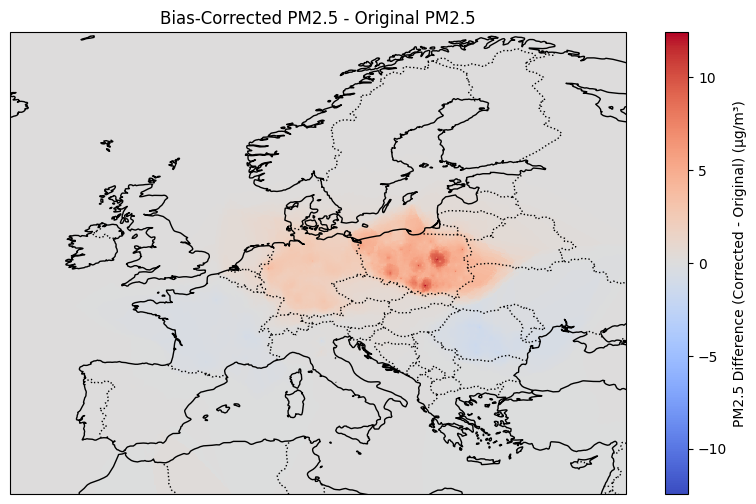

In [42]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# === Load Data ===
original_nc = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_nc = "BaseCase_PERT_PM25_rh50_YEARLY_corrected-2.nc"

# Open datasets
ds_original = xr.open_dataset(original_nc)
ds_corrected = xr.open_dataset(corrected_nc)

# Extract PM2.5 data
pm25_original = ds_original["SURF_ug_PM25_rh50"].values.squeeze()
pm25_corrected = ds_corrected["SURF_ug_PM25_rh50_corrected"].values.squeeze()

# Compute difference
pm25_difference = pm25_corrected - pm25_original

# Extract coordinates
lons = ds_original["lon"].values
lats = ds_original["lat"].values

# === Define a logarithmic normalization ===
norm = mcolors.CenteredNorm(vcenter=0)  # Center around 0 for positive and negative changes

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot PM2.5 difference using pcolormesh with log scaling
mesh = ax.pcolormesh(lons, lats, pm25_difference, cmap='coolwarm', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with centered scale
plt.colorbar(mesh, label="PM2.5 Difference (Corrected - Original) (µg/m³)")

# Add coastlines and borders for geographic context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Title
plt.title("Bias-Corrected PM2.5 - Original PM2.5")

# Show the plot
plt.show()

# Close datasets
ds_original.close()
ds_corrected.close()



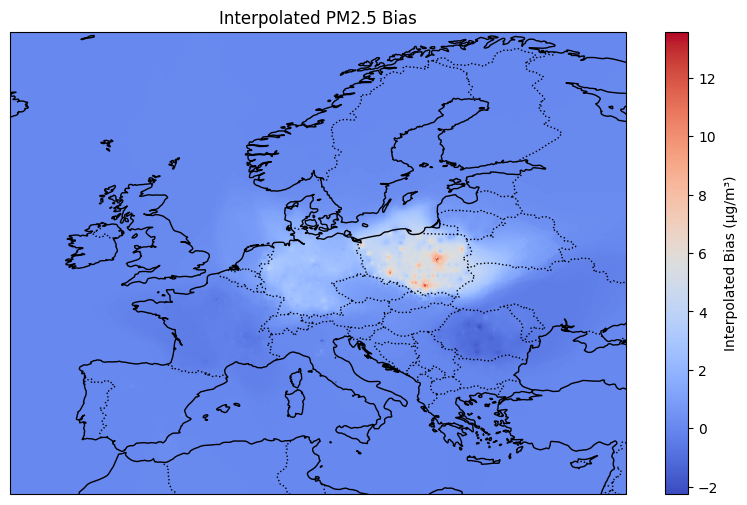

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Plot interpolated bias
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
mesh = ax.pcolormesh(lons, lats, z_bias, cmap="coolwarm", shading="auto", transform=ccrs.PlateCarree())
plt.colorbar(mesh, label="Interpolated Bias (µg/m³)")
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")
plt.title("Interpolated PM2.5 Bias")
plt.show()


# IDW Batch Processing

## chunks = 4

In [14]:
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy.spatial import cKDTree
from tqdm import tqdm

# === Load Data ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute bias (difference between observed and modeled values)
df["bias"] = df["SURF_ug_PM25_rh50"] - df["nearest_SURF_ug_PM25_rh50"]

# Load NetCDF file
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

# Extract NetCDF grid coordinates
lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]

# Create a meshgrid of lat/lon
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
points_grid = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])

# Prepare station data points and biases
station_points = df[["nearest_grid_lon", "nearest_grid_lat"]].values
bias_values = df["bias"].values

# Build KDTree for efficient nearest neighbor search
tree = cKDTree(station_points)

# === IDW Interpolation Function ===
def idw_interpolation(grid_points, station_points, values, power=2):
    interpolated = np.zeros(grid_points.shape[0])

    for i in tqdm(range(grid_points.shape[0]), desc="Interpolating IDW", unit="grid point"):
        dists, idxs = tree.query(grid_points[i], k=5)  # Consider 5 nearest stations

        if np.any(dists == 0):  # Exact match case
            interpolated[i] = values[idxs[dists == 0]][0]
        else:
            weights = 1 / (dists ** power)
            interpolated[i] = np.sum(weights * values[idxs]) / np.sum(weights)

    return interpolated

# === Perform IDW Interpolation in Small Groups ===
# Define number of chunks (for example, divide the grid into 4 equal parts)
chunks = 4
chunk_size = len(points_grid) // chunks

# Initialize an empty array to store the results
interpolated_bias_total = np.zeros_like(pm25_modeled.ravel())

# Process each chunk
for chunk_idx in range(chunks):
    # Define the start and end indices for the chunk
    start_idx = chunk_idx * chunk_size
    end_idx = (chunk_idx + 1) * chunk_size if chunk_idx < chunks - 1 else len(points_grid)

    # Extract the chunk of grid points
    chunk_grid_points = points_grid[start_idx:end_idx]

    # Perform IDW on the chunk
    chunk_interpolated_bias = idw_interpolation(chunk_grid_points, station_points, bias_values)

    # Store the interpolated values for this chunk in the correct position
    interpolated_bias_total[start_idx:end_idx] = chunk_interpolated_bias

# Reshape the result to match the grid shape
interpolated_bias_total = interpolated_bias_total.reshape(pm25_modeled.shape)

# Apply correction
corrected_pm25 = pm25_modeled + interpolated_bias_total

# Save the corrected values in a new NetCDF file (without modifying the original file)
corrected_netcdf_path = "corrected_pm25-4.nc"
new_dataset = nc.Dataset(corrected_netcdf_path, "w", format="NETCDF4")

# Create dimensions
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])

# Create variables
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
pm25_var = new_dataset.createVariable("SURF_ug_PM25_rh50", "f4", ("lat", "lon"))

# Assign data to the new file
lat_var[:] = lat
lon_var[:] = lon
pm25_var[:, :] = corrected_pm25

# Close new NetCDF file
new_dataset.close()

# Close the original dataset without making changes
dataset.close()

print("Bias correction using IDW in chunks completed successfully! Corrected NetCDF file saved as", corrected_netcdf_path)


Interpolating IDW: 100%|██████████| 101726/101726 [00:09<00:00, 11067.11grid point/s]

Bias correction using IDW in chunks completed successfully! Corrected NetCDF file saved as corrected_pm25-4.nc


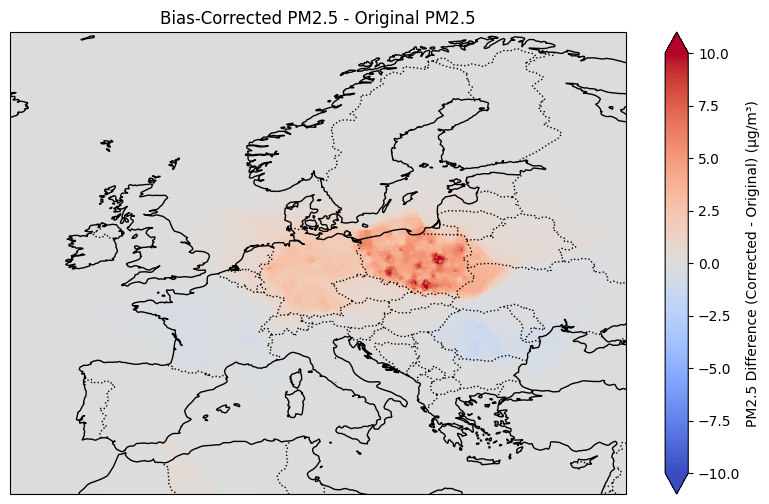

In [15]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# === Load Data ===
original_nc = "BaseCase_PERT_PM25_rh50_YEARLY.nc"  # Original modeled NetCDF file
corrected_nc = "corrected_pm25-4.nc"  # Corrected NetCDF file

# Open datasets
ds_original = xr.open_dataset(original_nc)
ds_corrected = xr.open_dataset(corrected_nc)

# Extract PM2.5 data
pm25_original = ds_original["SURF_ug_PM25_rh50"].values.squeeze()
pm25_corrected = ds_corrected["SURF_ug_PM25_rh50"].values.squeeze()

# Compute difference (Corrected - Original)
pm25_difference = pm25_corrected - pm25_original

# Extract coordinates
lons = ds_original["lon"].values
lats = ds_original["lat"].values

# === Define a centered color scale for the difference plot ===
# Pass vmin and vmax directly into Normalize
vmin = -10  # Set the minimum value for colorbar
vmax = 10   # Set the maximum value for colorbar
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot PM2.5 difference using pcolormesh with defined vmin and vmax
mesh = ax.pcolormesh(lons, lats, pm25_difference, cmap='coolwarm', shading='auto', transform=ccrs.PlateCarree(),
                     norm=norm)

# Add a colorbar with defined limits
plt.colorbar(mesh, label="PM2.5 Difference (Corrected - Original) (µg/m³)", extend="both")

# Add coastlines and borders for geographic context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Title
plt.title("Bias-Corrected PM2.5 - Original PM2.5")

# Show the plot
plt.show()

# Close datasets
ds_original.close()
ds_corrected.close()



# IDW Rescaled Additive Method

In [18]:
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy.spatial import cKDTree
from tqdm import tqdm

# === Load Data ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute bias (difference between observed and modeled values)
df["bias"] = df["SURF_ug_PM25_rh50"] - df["nearest_SURF_ug_PM25_rh50"]

# Load NetCDF file
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

# Extract NetCDF grid coordinates
lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]

# Create a meshgrid of lat/lon
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
points_grid = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])

# Prepare station data points and biases
station_points = df[["nearest_grid_lon", "nearest_grid_lat"]].values
bias_values = df["bias"].values

# Build KDTree for efficient nearest neighbor search
tree = cKDTree(station_points)

# === IDW Rescaled Additive Method ===
def idw_rescaled_additive(grid_points, station_points, values, pm25_modeled, power=2):
    interpolated = np.zeros(grid_points.shape[0])

    for i in tqdm(range(grid_points.shape[0]), desc="Interpolating IDW Rescaled Additive", unit="grid point"):
        # Find the nearest 5 stations
        dists, idxs = tree.query(grid_points[i], k=5)

        if np.any(dists == 0):  # Exact match case
            interpolated[i] = values[idxs[dists == 0]][0]
        else:
            weights = 1 / (dists ** power)  # Inverse distance weights
            # Find the grid indices from the station coordinates with tolerance
            station_lons, station_lats = station_points[idxs].T

            # Use np.argmin to find the closest grid point index
            grid_indices = np.array([np.argmin(np.abs(lon - lon_val)) for lon_val in station_lons])
            lat_indices = np.array([np.argmin(np.abs(lat - lat_val)) for lat_val in station_lats])

            # Calculate scaling factor for rescaled additive correction
            scaling_factor = np.sum(weights * pm25_modeled[lat_indices, grid_indices]) / np.sum(weights)
            interpolated[i] = scaling_factor * np.sum(weights * values[idxs]) / np.sum(weights)

    return interpolated

# === Perform IDW Rescaled Additive Interpolation ===
print("\nInterpolating bias using IDW Rescaled Additive method...")
interpolated_bias_rescaled = idw_rescaled_additive(points_grid, station_points, bias_values, pm25_modeled)

# Reshape the result to match the grid shape
interpolated_bias_rescaled = interpolated_bias_rescaled.reshape(pm25_modeled.shape)

# Apply correction
corrected_pm25_rescaled = pm25_modeled + interpolated_bias_rescaled

# Save the corrected values in a new NetCDF file (without modifying the original file)
corrected_netcdf_path = "corrected_pm25_rescaled.nc"
new_dataset = nc.Dataset(corrected_netcdf_path, "w", format="NETCDF4")

# Create dimensions
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])

# Create variables
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
pm25_var = new_dataset.createVariable("SURF_ug_PM25_rh50", "f4", ("lat", "lon"))

# Assign data to the new file
lat_var[:] = lat
lon_var[:] = lon
pm25_var[:, :] = corrected_pm25_rescaled

# Close new NetCDF file
new_dataset.close()

# Close the original dataset without making changes
dataset.close()

print("Bias correction using IDW Rescaled Additive method completed successfully! Corrected NetCDF file saved as", corrected_netcdf_path)



Interpolating bias using IDW Rescaled Additive method...


Interpolating IDW Rescaled Additive: 100%|██████████| 406901/406901 [06:58<00:00, 971.48grid point/s] 

Bias correction using IDW Rescaled Additive method completed successfully! Corrected NetCDF file saved as corrected_pm25_rescaled.nc


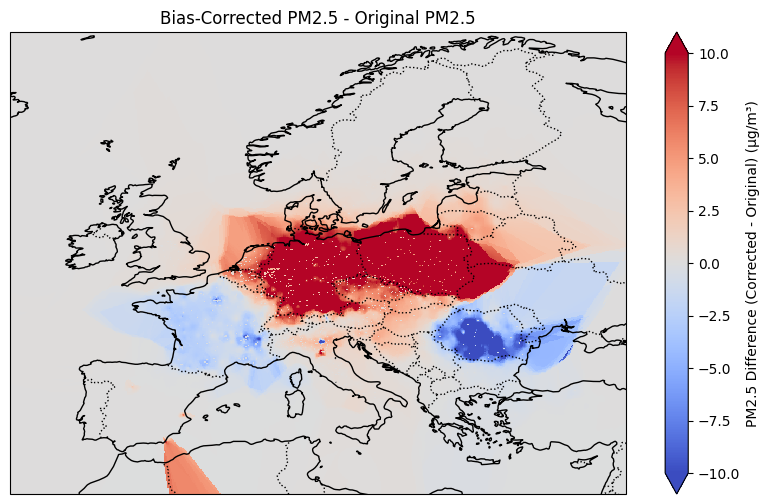

In [19]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# === Load Data ===
original_nc = "BaseCase_PERT_PM25_rh50_YEARLY.nc"  # Original modeled NetCDF file
corrected_nc = "corrected_pm25_rescaled.nc"  # Corrected NetCDF file

# Open datasets
ds_original = xr.open_dataset(original_nc)
ds_corrected = xr.open_dataset(corrected_nc)

# Extract PM2.5 data
pm25_original = ds_original["SURF_ug_PM25_rh50"].values.squeeze()
pm25_corrected = ds_corrected["SURF_ug_PM25_rh50"].values.squeeze()

# Compute difference (Corrected - Original)
pm25_difference = pm25_corrected - pm25_original

# Extract coordinates
lons = ds_original["lon"].values
lats = ds_original["lat"].values

# === Define a centered color scale for the difference plot ===
# Pass vmin and vmax directly into Normalize
vmin = -10  # Set the minimum value for colorbar
vmax = 10   # Set the maximum value for colorbar
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot PM2.5 difference using pcolormesh with defined vmin and vmax
mesh = ax.pcolormesh(lons, lats, pm25_difference, cmap='coolwarm', shading='auto', transform=ccrs.PlateCarree(),
                     norm=norm)

# Add a colorbar with defined limits
plt.colorbar(mesh, label="PM2.5 Difference (Corrected - Original) (µg/m³)", extend="both")

# Add coastlines and borders for geographic context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Title
plt.title("Bias-Corrected PM2.5 - Original PM2.5")

# Show the plot
plt.show()

# Close datasets
ds_original.close()
ds_corrected.close()

